In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the ferry trips data
ferry_data = pd.read_csv('data/ferry_trips_data_large.csv')

# Display the first few rows to understand the structure
ferry_data.head()
# Summary of the dataset
ferry_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69358 entries, 0 to 69357
Data columns (total 38 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   route_id                                       69358 non-null  int64  
 1   route_name                                     69358 non-null  object 
 2   ferry_name                                     69358 non-null  object 
 3   ferry_id                                       69358 non-null  int64  
 4   terminal_departure                             69358 non-null  object 
 5   terminal_arrival                               69358 non-null  object 
 6   time_departure                                 69358 non-null  object 
 7   cars_outbound                                  69358 non-null  int64  
 8   trucks_outbound                                69358 non-null  int64  
 9   trucks_with_trailer_outbound                   693

## Q1 What is the total fuel cost for ferry Jupiter in January 2024 assuming that the price per liter is 20 sek?

In [19]:
# Convert 'time_departure' to datetime objects for filtering
ferry_data['time_departure'] = pd.to_datetime(ferry_data['time_departure'])

# Filter data for ferry 'Jupiter' and January 2024
jupiter_jan_data = ferry_data[
    (ferry_data['ferry_name'] == 'Jupiter') &
    (ferry_data['time_departure'].dt.month == 1) &
    (ferry_data['time_departure'].dt.year == 2024)
]

# Calculate total fuel consumption (handling potential NaNs by filling with 0)
total_fuel_consumption = (
    jupiter_jan_data['fuelcons_outbound_l'].fillna(0).sum() +
    jupiter_jan_data['fuelcons_inbound_l'].fillna(0).sum()
)

# Assuming a fuel cost per liter (you might need to adjust this)
# Let's assume a fuel cost of 10 SEK per liter for example purposes
fuel_cost_per_liter = 20

# Calculate the total fuel cost
total_fuel_cost = total_fuel_consumption * fuel_cost_per_liter

print(f"Total fuel consumption for ferry Jupiter in January 2024: {total_fuel_consumption:.2f} liters")
print(f"Total fuel cost for ferry Jupiter in January 2024: {total_fuel_cost:.2f} SEK")

Total fuel consumption for ferry Jupiter in January 2024: 12709.34 liters
Total fuel cost for ferry Jupiter in January 2024: 254186.70 SEK


## Q2 What is the average speed of ferry Jupiter? (in km/h)


In [20]:
# Convert time columns to datetime objects
ferry_data['start_time_outbound'] = pd.to_datetime(ferry_data['start_time_outbound'])
ferry_data['end_time_outbound'] = pd.to_datetime(ferry_data['end_time_outbound'])
ferry_data['start_time_inbound'] = pd.to_datetime(ferry_data['start_time_inbound'])
ferry_data['end_time_inbound'] = pd.to_datetime(ferry_data['end_time_inbound'])

# Filter data for ferry 'Jupiter'
jupiter_data = ferry_data[ferry_data['ferry_name'] == 'Jupiter'].copy()

# Function to calculate trip duration in hours, handling potential NaNs
def calculate_duration(start_time, end_time):
    if pd.notna(start_time) and pd.notna(end_time):
        duration = (end_time - start_time).total_seconds() / 3600
        return duration
    return None

# Apply the function to calculate outbound and inbound durations
jupiter_data['duration_outbound'] = jupiter_data.apply(
    lambda row: calculate_duration(row['start_time_outbound'], row['end_time_outbound']), axis=1
)
jupiter_data['duration_inbound'] = jupiter_data.apply(
    lambda row: calculate_duration(row['start_time_inbound'], row['end_time_inbound']), axis=1
)

# Calculate average speed for outbound trips (distance in nautical miles, duration in hours)
jupiter_data['speed_outbound_knots'] = jupiter_data.apply(
    lambda row: row['distance_outbound_nm'] / row['duration_outbound']
    if row['duration_outbound'] else None,
    axis=1
)

# Calculate average speed for inbound trips
jupiter_data['speed_inbound_knots'] = jupiter_data.apply(
    lambda row: row['distance_inbound_nm'] / row['duration_inbound']
    if row['duration_inbound'] else None,
    axis=1
)

# Calculate the average of all valid speed values
valid_speeds = pd.concat([jupiter_data['speed_outbound_knots'].dropna(), jupiter_data['speed_inbound_knots'].dropna()])

if not valid_speeds.empty:
    average_speed_knots = valid_speeds.mean()
    print(f"The average speed of ferry Jupiter is: {average_speed_knots:.2f} knots")

    # Convert knots to km/h and mph for better understanding
    average_speed_kmh = average_speed_knots * 1.852
    average_speed_mph = average_speed_knots * 1.15078
    print(f"Average speed in km/h: {average_speed_kmh:.2f} km/h")
    print(f"Average speed in mph: {average_speed_mph:.2f} mph")
else:
    print("Could not calculate the average speed for ferry Jupiter due to missing distance or time information.")

The average speed of ferry Jupiter is: 6.23 knots
Average speed in km/h: 11.55 km/h
Average speed in mph: 7.17 mph


## Q3 How many vehicles left at the terminal are there in total? 

In [27]:
# Total vehicles left at the terminal
vehicles_left_total = ferry_data['vehicles_left_at_terminal_outbound'].sum() + ferry_data['vehicles_left_at_terminal_inbound'].sum()

# Average vehicles left at terminal per trip
vehicles_left_avg = ferry_data[['vehicles_left_at_terminal_outbound', 'vehicles_left_at_terminal_inbound']].mean()

print(f"Total vehicles left: {vehicles_left_total}")
print(vehicles_left_avg)

Total vehicles left: 44748
vehicles_left_at_terminal_outbound    0.318175
vehicles_left_at_terminal_inbound     0.326999
dtype: float64


## Q4 How many vehicles on average are left at the terminal per trip for ferry Jupiter during summer months?

In [29]:
# Convert 'time_departure' to datetime objects for filtering
ferry_data['time_departure'] = pd.to_datetime(ferry_data['time_departure'], errors='coerce')

# Filter data for ferry 'Jupiter'
jupiter_data = ferry_data[ferry_data['ferry_name'] == 'Jupiter'].copy()

# Define summer months (June, July, August)
summer_months = [6, 7, 8]

# Filter Jupiter data for summer months, handling potential NaT values
jupiter_summer_data = jupiter_data[
    jupiter_data['time_departure'].notna() &
    jupiter_data['time_departure'].dt.month.isin(summer_months)
]

# Calculate the total vehicles left at the terminal during summer for Jupiter
# Assuming the columns for vehicles left are:
vehicles_left_cols = ['cars_outbound', 'trucks_outbound', 'trucks_with_trailer_outbound',
                      'cars_inbound', 'trucks_inbound', 'trucks_with_trailer_inbound']

total_left_summer_jupiter = jupiter_summer_data[vehicles_left_cols].fillna(0).sum().sum()

# Calculate the total number of trips made by Jupiter during the summer
total_trips_summer_jupiter = len(jupiter_summer_data)

# Calculate the average amount of vehicles left per trip for Jupiter during summer
average_left_summer_jupiter = total_left_summer_jupiter / total_trips_summer_jupiter if total_trips_summer_jupiter > 0 else 0

print(f"Total vehicles left at the terminal for ferry Jupiter during summer: {total_left_summer_jupiter}")
print(f"Average amount of vehicles left at the terminal per trip for ferry Jupiter during summer: {average_left_summer_jupiter:.2f}")


Total vehicles left at the terminal for ferry Jupiter during summer: 199263
Average amount of vehicles left at the terminal per trip for ferry Jupiter during summer: 43.21


## Q5 Which route has the highest average distance travelled, considering both outbound and inbound directions?

Correct answer
The route with the highest average distance travelled is: Aspöleden with an average distance of 3.22 NM.
Relevant context
       route_name ferry_name             direction  average_distance_nm_leg
0       Aspöleden      Yxlan  distance_outbound_nm                 3.212223
1  Furusundsleden  Merkurius  distance_outbound_nm                 0.235259
2   Ljusteröleden    Jupiter  distance_outbound_nm                 0.569472
3    Oxdjupsleden  Fragancia  distance_outbound_nm                 0.250244
4   Vaxholmsleden       Nina  distance_outbound_nm                 0.488404
5       Aspöleden      Yxlan   distance_inbound_nm                 3.230830
6  Furusundsleden  Merkurius   distance_inbound_nm                 0.234637
7   Ljusteröleden    Jupiter   distance_inbound_nm                 0.567139
8    Oxdjupsleden  Fragancia   distance_inbound_nm                 0.247365
9   Vaxholmsleden       Nina   distance_inbound_nm                 0.487763


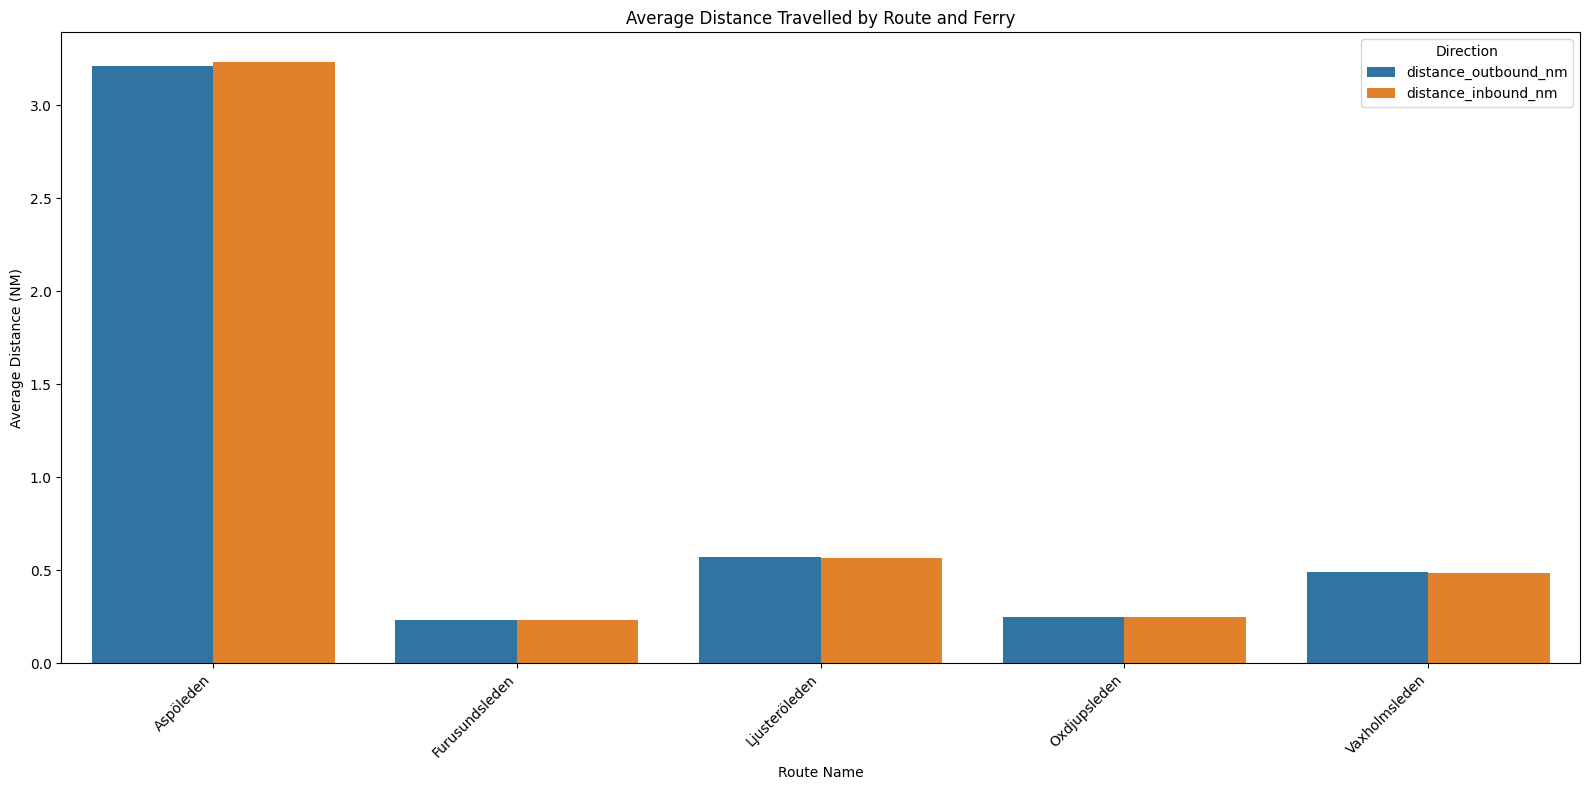

In [8]:
def distance_travelled_analysis(df):
    distance_data = df[['route_name', 'ferry_name', 'distance_outbound_nm', 'distance_inbound_nm']].copy() # Added .copy() to avoid SettingWithCopyWarning

    # Drop null values
    distance_data = distance_data.dropna()

    # Calculate the average distance for each leg (outbound and inbound)
    distance_by_route_ferry = distance_data.groupby(['route_name', 'ferry_name'])[['distance_outbound_nm', 'distance_inbound_nm']].mean().reset_index()

    # Calculate the overall average distance for each route and ferry
    distance_by_route_ferry['average_distance_nm'] = (distance_by_route_ferry['distance_outbound_nm'] + distance_by_route_ferry['distance_inbound_nm']) / 2

    # Group by route_name and calculate the mean of the overall average distance
    average_distance_by_route = distance_by_route_ferry.groupby('route_name')['average_distance_nm'].mean().reset_index()

    # Find the route with the highest average distance
    route_with_highest_distance = average_distance_by_route.loc[average_distance_by_route['average_distance_nm'].idxmax()]

    print(f"The route with the highest average distance travelled is: {route_with_highest_distance['route_name']} with an average distance of {route_with_highest_distance['average_distance_nm']:.2f} NM.")

    distance_by_route_ferry_melted = distance_by_route_ferry.melt(
        id_vars=['route_name', 'ferry_name'],
        value_vars=['distance_outbound_nm', 'distance_inbound_nm'],
        var_name='direction',
        value_name='average_distance_nm_leg' # Renamed to avoid confusion
    )
    print("Relevant context")
    print(distance_by_route_ferry_melted.head(10))
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=distance_by_route_ferry_melted,
        x='route_name',
        y='average_distance_nm_leg',
        hue='direction'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Distance Travelled by Route and Ferry')
    plt.xlabel('Route Name')
    plt.ylabel('Average Distance (NM)')
    plt.legend(title='Direction')
    plt.tight_layout()
    plt.show()

# Call the function
print("Correct answer")
distance_travelled_analysis(ferry_data)

## Q6 What is the average distance travelled on Ljusteröleden?

In [38]:
def average_distance_on_ljusteroleden(df):
    ljusteroleden_data = df[df['route_name'] == 'Ljusteröleden'].copy()

    if not ljusteroleden_data.empty:
        # Calculate the average distance for each trip on Ljusteröleden
        ljusteroleden_data['average_trip_distance_nm'] = (
            ljusteroleden_data['distance_outbound_nm'] + ljusteroleden_data['distance_inbound_nm']
        ) / 2

        # Calculate the overall average distance for Ljusteröleden
        average_distance = ljusteroleden_data['average_trip_distance_nm'].mean()

        print(f"The average distance travelled on Ljusteröleden is: {average_distance:.2f} NM.")
    else:
        print("Data for Ljusteröleden not found in the provided DataFrame.")


In [39]:
average_distance_on_ljusteroleden(ferry_data)

The average distance travelled on Ljusteröleden is: 0.57 NM.


## Q7 

In [5]:
import pandas as pd

# Assume demand_analysis function remains the same as you provided:
def demand_analysis(df):
    # Ensure the time_departure column is datetime type and extract the hour
    # Making a copy to avoid SettingWithCopyWarning if ferry_data is used elsewhere
    df = df.copy()
    df['time_departure'] = pd.to_datetime(df['time_departure'], errors='coerce') # Add errors='coerce' for robustness
    df.dropna(subset=['time_departure'], inplace=True) # Drop rows where conversion failed
    df['hour'] = df['time_departure'].dt.hour

    # Aggregate data by 'route_name', 'ferry_name', and 'hour'
    demand_by_hour_route = df.groupby(['route_name', 'ferry_name', 'hour']).agg(
        # Use 'size' to count the number of departures per hour if needed
        departures = ('time_departure', 'size'),
        cars_outbound = ('cars_outbound', 'sum'),
        trucks_outbound = ('trucks_outbound', 'sum'),
        trucks_with_trailer_outbound = ('trucks_with_trailer_outbound', 'sum'),
        passenger_car_equivalent_outbound = ('passenger_car_equivalent_outbound', 'sum'),
        passenger_car_equivalent_inbound = ('passenger_car_equivalent_inbound', 'sum')
    ).reset_index()
    return demand_by_hour_route

def find_peak_hour_demand(df, route_name, peak_start_hour=7, peak_end_hour=9):
    """
    Identifies the hour with the highest outbound demand (measured by PCE)
    on a specific route during peak hours.

    Args:
        df (pd.DataFrame): DataFrame containing aggregated hourly ferry demand data,
                           output of demand_analysis.
        route_name (str): The name of the route to analyze.
        peak_start_hour (int): The starting hour of the morning peak (inclusive).
        peak_end_hour (int): The ending hour of the morning peak (inclusive).

    Returns:
        tuple: A tuple containing (peak_hour, max_pce_outbound),
               or (None, None) if no data is found for the specified criteria.
    """
    # Filter for the specific route and morning peak hours
    morning_peak_data = df[
        (df['route_name'] == route_name) &
        (df['hour'] >= peak_start_hour) &
        (df['hour'] <= peak_end_hour)
    ].copy() # Use .copy() to avoid potential SettingWithCopyWarning

    if morning_peak_data.empty:
        print(f"No data found for route '{route_name}' during hours {peak_start_hour}-{peak_end_hour}.")
        return None, None

    # Since data is already aggregated by hour (and potentially ferry, though maybe only one),
    # find the row with the maximum outbound PCE within the filtered set.
    # idxmax() returns the index of the first occurrence of the maximum value.
    idx_max_pce = morning_peak_data['passenger_car_equivalent_outbound'].idxmax()

    # Get the corresponding row
    peak_hour_data = morning_peak_data.loc[idx_max_pce]

    peak_hour = peak_hour_data['hour']
    max_pce_outbound = peak_hour_data['passenger_car_equivalent_outbound']

    # Optional: You could also return truck demand for that specific hour
    # trucks_at_peak = peak_hour_data['trucks_outbound']

    return peak_hour, max_pce_outbound


# Analyze the demand data
demand_data_processed = demand_analysis(ferry_data)
print("Processed Demand Data:")
print(demand_data_processed)
print("-" * 30)

# Specify the route you want to analyze
selected_route = 'Aspöleden'
start_hour = 6
end_hour = 23

# Find the hour with the highest demand during morning peak hours
peak_hour, max_pce = find_peak_hour_demand(demand_data_processed, selected_route, start_hour, end_hour)

if peak_hour is not None:
    print(f"For the route '{selected_route}', the peak hour between ({start_hour}:00-{end_hour}:59) with the highest outbound demand is:")
    print(f"Hour: {peak_hour}:00 - {peak_hour}:59")
    print(f"Maximum Passenger Car Equivalent (PCE) during that hour: {max_pce}")
else:
    print(f"Could not determine the peak hour for route '{selected_route}' during the specified times.")

Processed Demand Data:
        route_name ferry_name  hour  departures  cars_outbound  \
0        Aspöleden      Yxlan     0           2             17   
1        Aspöleden      Yxlan     3           1              8   
2        Aspöleden      Yxlan     5         356            481   
3        Aspöleden      Yxlan     6         251           1195   
4        Aspöleden      Yxlan     7         351           2832   
..             ...        ...   ...         ...            ...   
107  Vaxholmsleden       Nina    19         888          18727   
108  Vaxholmsleden       Nina    20         668          11462   
109  Vaxholmsleden       Nina    21         672           9374   
110  Vaxholmsleden       Nina    22         676           6424   
111  Vaxholmsleden       Nina    23         677           3700   

     trucks_outbound  trucks_with_trailer_outbound  \
0                  3                             0   
1                  1                             0   
2                 17  